In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Pixel number which can be added or subtracted to crop the image (DEFAULT = 50)
CROP_PERCENTAGE = 50

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\pyth

In [3]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [4]:
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
dataset_dir = os.path.join(ROOT_DIR,"data_crop")
print("Dataset Directory: ", dataset_dir)
# Load mask
def load_mask(height, width, polygons):
    mask = np.zeros([height, width, 1],dtype=np.uint8)
    rr, cc = skimage.draw.polygon(polygons['all_points_y'], polygons['all_points_x'])
    mask[rr, cc, 0] = 1
    return mask

Dataset Directory:  C:\Users\kwon\Mask_RCNN\data_crop


In [5]:
# Load original annotation
def load_annotation():
    annotations = json.load(open(os.path.join(dataset_dir, "annotation/train_val_091520(3).json")))
    annotations = list(annotations.values())
    annotations = [a for a in annotations if a['regions']]
    return annotations

In [6]:
def new_annotations():
    origin_a = load_annotation()
    last_check = 0
    
    for a in origin_a:
        image_path = os.path.join(ROOT_DIR, "/Users/kwon/Mask_RCNN/bridge/train/"+a['filename'])
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        print("Original Image height and width: ", height, width)
        
        polygon = []
        index = 0
        last_check = last_check + 1
        for r in a['regions']:
            polygon = r['shape_attributes']
            # print("Shape Attributes: ", polygon)
            
            # load only 1 mask from the images
            mask = load_mask(height, width, polygon)
            # Extract bbox from mask to crop the images
            from mrcnn import utils
            bbox = utils.extract_bboxes(mask)
            
            # New bounding box to crop the image with only 1 obejct annotated
            new_y1 = 0 if ((bbox[0][0] - CROP_PERCENTAGE) <= 0) else (bbox[0][0] - CROP_PERCENTAGE) 
            new_x1 = 0 if ((bbox[0][1] - CROP_PERCENTAGE) <= 0) else (bbox[0][1] - CROP_PERCENTAGE) 
            new_y2 = height if ((bbox[0][2] + CROP_PERCENTAGE) >= height) else (bbox[0][2] + CROP_PERCENTAGE) 
            new_x2 = width if ((bbox[0][3] + CROP_PERCENTAGE) >= width) else (bbox[0][3] + CROP_PERCENTAGE) 
            newbbox = np.array([new_y1, new_x1, new_y2, new_x2])
            # print("New bounding box: ", newbbox)
            
            # New points_X, points_Y coordinate in new image
            # print("Type of all pints:", type(polygon['all_points_x']))
            newpolygon_x = np.array(polygon['all_points_x']) - new_x1
            newpolygon_y = np.array(polygon['all_points_y']) - new_y1
            
            # print("New coordinate of all x points and all y points: ", newpolygon_x, newpolygon_y)

            # Save new cropped image
            new_image = image[new_y1:new_y2, new_x1:new_x2]
            skimage.io.imshow(new_image)
            new_filename = a['filename'].split('.')[0] + "_" + str(index) + "." + a['filename'].split('.')[1]
            skimage.io.imsave(new_filename, new_image)
            index = index + 1
            check = False if ((index>=len(a['regions'])) & (last_check>=len(origin_a))) else True
            
            save_new_annotation(newpolygon_x, newpolygon_y, r['region_attributes'], new_filename, a['file_attributes'], check)

In [7]:
def save_new_annotation(newpolygon_x, newpolygon_y, class_attribute, filename, file_attribute, final_check=True):
    # New annotation
    new_region = {}
    new_region['shape_attributes'] = {"name":"polygon", 
                                  "all_points_x": list(newpolygon_x), 
                                  "all_points_y": list(newpolygon_y)}
    new_region['region_attributes'] = class_attribute

    new_annotation = {}
    new_annotation['filename'] = filename
    
    # Need to modify
    new_annotation['size'] = os.path.getsize(filename)
    new_annotation['regions'] = [new_region]
    new_annotation['file_attributes'] = file_attribute

    # new_annotation = list(new_annotation)
    # print("New annotation: ", new_annotation)

    # file attach
    fin = {}
    newkey = filename + str(new_annotation['size'])
    # print("Newkey: ", newkey)
    fin[newkey] = new_annotation
    
#    annotation_file = open("sample3.json", "a+")
    clean_fin = json.dumps(fin, cls=NpEncoder)
    annotation_file.write(clean_fin[1:len(clean_fin)-1])
    annotation_file.write(',') if final_check else annotation_file.write('')
#    annotation_file.close()
        

Original Image height and width:  534 414
working? 
not working?
Original Image height and width:  320 320
working? 
not working?
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  500 375
working? 
not working?
Original Image height and width:  212 238
working? 
not working?
working? 
not working?
Original Image height and width:  506 900
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  238 212
working? 
not working?
working? 
not working?
Original Image height and width:  373 200
working? 
not working?
working? 
not working?
Original Image height and width:  194 259
working? 
not working?
Original Image height and width:  400 300
working? 
not working?
Original Image height and width:  194 259
working? 
not working?
Original Image height and width:  183 275
working? 
not working?
Original Image height and width:  160 314
working? 
not working?
working? 
not working?
working? 
not

working? 
not working?
Original Image height and width:  650 899
working? 
not working?
working? 
not working?
Original Image height and width:  183 275
working? 
not working?
working? 
not working?
Original Image height and width:  1712 2288
working? 
not working?
Original Image height and width:  600 802
working? 
not working?
Original Image height and width:  186 271
working? 
not working?
working? 
not working?
Original Image height and width:  1712 2288
working? 
not working?
Original Image height and width:  193 261
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  1712 2288
working? 
not working?
Original Image height and width:  259 194
working? 
not working?
Original Image height and width:  600 802
working? 
not working?
Original Image height and width:  168 299
working? 
not working?
working? 
not working?
Original Image height and width:  1712 2288
working? 
not working?
Original Image height and width:  183 275
working? 

working? 
not working?
Original Image height and width:  3360 5184
working? 
not working?
Original Image height and width:  900 634
working? 
not working?
Original Image height and width:  534 414
working? 
not working?
Original Image height and width:  534 414
working? 
not working?
Original Image height and width:  534 414
working? 
not working?
Original Image height and width:  500 375
working? 
not working?
Original Image height and width:  500 375
working? 
not working?
Original Image height and width:  500 375
working? 
not working?
Original Image height and width:  506 900
working? 
not working?
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  506 900
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  506 900
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  373 200
working? 
not working?
working? 
not working?
Original Im

not working?
Original Image height and width:  384 491
working? 
not working?
working? 
not working?
Original Image height and width:  384 491
working? 
not working?
working? 
not working?
Original Image height and width:  892 1200
working? 
not working?
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  892 1200
working? 
not working?
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  892 1200
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  285 480
working? 
not working?
Original Image height and width:  285 480
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  285 480
working? 
not working?
working? 
not working?
Original Image height and width:  342 512
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  342 512
working? 
no

working? 
not working?
working? 
not working?
Original Image height and width:  172 293
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  225 225
working? 
not working?
Original Image height and width:  212 238
working? 
not working?
Original Image height and width:  212 238
working? 
not working?
Original Image height and width:  212 238
working? 
not working?
Original Image height and width:  202 250
working? 
not working?
Original Image height and width:  202 250
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  202 250
working? 
not working?
Original Image height and width:  183 275
working? 
not working?
working? 
not working?
Original Image height and width:  183 275
working? 
not working?
working? 
not working?
Original Image height and width:  183 275
working? 
not working?
working? 
not working?
Original Image height and width:  237 212
working? 
not working?
Original Imag

working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  1280 960
working? 
not working?
Original Image height and width:  658 987
working? 
not working?
Original Image height and width:  658 987
working? 
not working?
working? 
not working?
working? 
not working?
Original Image height and width:  4272 2848
working? 
not working?
Original Image height and width:  4272 2848
working? 
not working?
Original Image height and width:  4272 2848
working? 
not working?
Original Image height and width:  934 960
working? 
not working?
working? 
not working?
Original Image height and width:  934 960
working?

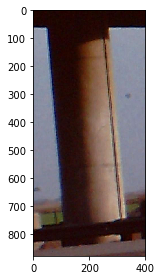

In [8]:
annotation_file = open("sample3.json", "w+")
annotation_file.write("{")
annotation_file.close()

annotation_file = open("sample3.json", "a+")
new_annotations()
annotation_file.write("}")
annotation_file.close()
